In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pulp
from pathlib import Path

sns.set(style="whitegrid")
DATA_DIR = Path("data")

In [6]:
import pandas as pd

df = pd.read_csv("Historical Product Demand.csv")
print("Dataset Shape:", df.shape)
df.head()



Dataset Shape: (1048575, 5)


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [7]:
df.describe()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,1048575,1048575,1048575,1037336,1048575
unique,2160,4,33,1729,3828
top,Product_1359,Whse_J,Category_019,2013/9/27,1000
freq,16936,764447,481099,2075,112682


In [10]:

# Convert Order_Demand to numeric, forcing errors to NaN
df['Order_Demand'] = pd.to_numeric(df['Order_Demand'], errors='coerce')

# Replace NaN with 0 (optional, depending on your data handling preference)
df['Order_Demand'] = df['Order_Demand'].fillna(0)

# Extract month period
df['Month'] = df['Date'].dt.to_period('M')

# Group by Product and Month
monthly_demand = df.groupby(['Product_Code', 'Month'])['Order_Demand'].sum().reset_index()

# Take absolute values
monthly_demand['Order_Demand'] = monthly_demand['Order_Demand'].abs()

monthly_demand.head()


,Product_Code,Month,Order_Demand
0,Product_0001,2011-12,300.0
1,Product_0001,2012-01,9700.0
2,Product_0001,2012-02,13000.0
3,Product_0001,2012-03,14100.0
4,Product_0001,2012-04,3300.0


In [11]:
!pip install pulp


In [12]:
import pulp

# Assume some parameters (you can adjust these or load from a file)
production_capacity = 5000  # units per month
holding_cost_per_unit = 2   # $ per unit per month
selling_price_per_unit = 20 # $ per unit

# Filter for one product for example
product_id = monthly_demand['Product_Code'].unique()[0]
product_data = monthly_demand[monthly_demand['Product_Code'] == product_id]

# Create LP problem
model = pulp.LpProblem("Inventory_Optimization", pulp.LpMaximize)

# Decision variables: how many units to produce each month
months = list(product_data['Month'].astype(str))
production_vars = pulp.LpVariable.dicts("Prod", months, lowBound=0, cat='Integer')

# Objective: Maximize Profit = Revenue - Holding Cost
# Assuming holding cost applies to inventory not sold (simple case)
revenue = pulp.lpSum([production_vars[m] * selling_price_per_unit for m in months])
holding_cost = pulp.lpSum([production_vars[m] * holding_cost_per_unit for m in months])
model += revenue - holding_cost

# Constraints
for m, demand in zip(months, product_data['Order_Demand']):
    model += production_vars[m] >= demand  # Must meet demand
    model += production_vars[m] <= production_capacity  # Capacity constraint

# Solve
model.solve()
print("Status:", pulp.LpStatus[model.status])

# Show results
for m in months:
    print(f"Month {m}: Produce {production_vars[m].varValue} units")

print("Total Profit:", pulp.value(model.objective))


Status: Infeasible
Month 2011-12: Produce 5000.0 units
Month 2012-01: Produce 5000.0 units
Month 2012-02: Produce 5000.0 units
Month 2012-03: Produce 5000.0 units
Month 2012-04: Produce 5000.0 units
Month 2012-05: Produce 5000.0 units
Month 2012-06: Produce 5000.0 units
Month 2012-07: Produce 5000.0 units
Month 2012-08: Produce 5000.0 units
Month 2012-09: Produce 5000.0 units
Month 2012-10: Produce 5000.0 units
Month 2012-11: Produce 5000.0 units
Month 2012-12: Produce 5000.0 units
Month 2013-01: Produce 5000.0 units
Month 2013-02: Produce 5000.0 units
Month 2013-03: Produce 5000.0 units
Month 2013-04: Produce 5000.0 units
Month 2013-05: Produce 5000.0 units
Month 2013-06: Produce 5000.0 units
Month 2013-07: Produce 5000.0 units
Month 2013-08: Produce 5000.0 units
Month 2013-09: Produce 5000.0 units
Month 2013-10: Produce 5000.0 units
Month 2013-11: Produce 5000.0 units
Month 2013-12: Produce 5000.0 units
Month 2014-01: Produce 5000.0 units
Month 2014-02: Produce 5000.0 units
Month 201

In [13]:
for new_holding_cost in [1, 2, 5, 10]:
    model = pulp.LpProblem("Sensitivity_Test", pulp.LpMaximize)
    production_vars = pulp.LpVariable.dicts("Prod", months, lowBound=0, cat='Integer')

    revenue = pulp.lpSum([production_vars[m] * selling_price_per_unit for m in months])
    holding_cost = pulp.lpSum([production_vars[m] * new_holding_cost for m in months])
    model += revenue - holding_cost

    for m, demand in zip(months, product_data['Order_Demand']):
        model += production_vars[m] >= demand
        model += production_vars[m] <= production_capacity

    model.solve()
    print(f"Holding Cost = {new_holding_cost}: Profit = {pulp.value(model.objective)}")


Holding Cost = 1: Profit = 5795000.0
Holding Cost = 2: Profit = 5490000.0
Holding Cost = 5: Profit = 4575000.0
Holding Cost = 10: Profit = 3050000.0


In [14]:
# Ensure Order_Demand is numeric
df['Order_Demand'] = pd.to_numeric(df['Order_Demand'], errors='coerce').abs()

# Parameters (change as needed)
production_capacity = 1000  
selling_price_per_unit = 20  
holding_cost_per_unit = 2
production_cost_per_unit = 8  

# Group monthly demand
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.to_period('M')
monthly_demand = df.groupby('Month')['Order_Demand'].sum().reset_index()

# Calculate metrics
metrics = []
for _, row in monthly_demand.iterrows():
    month = str(row['Month'])
    demand = row['Order_Demand']
    
    produced = min(demand, production_capacity)  # Cap production to capacity
    revenue = produced * selling_price_per_unit
    holding_cost = produced * holding_cost_per_unit
    production_cost = produced * production_cost_per_unit
    profit = revenue - (holding_cost + production_cost)
    utilization = (produced / production_capacity) * 100
    
    metrics.append({
        "Month": month,
        "Demand": demand,
        "Produced": produced,
        "Revenue": revenue,
        "Holding_Cost": holding_cost,
        "Production_Cost": production_cost,
        "Profit": profit,
        "Utilization(%)": utilization
    })

# Create DataFrame
metrics_df = pd.DataFrame(metrics)

# Display
print("📊 Monthly Metrics:")
display(metrics_df)

# Overall summary
summary = {
    "Total Revenue": metrics_df["Revenue"].sum(),
    "Total Holding Cost": metrics_df["Holding_Cost"].sum(),
    "Total Production Cost": metrics_df["Production_Cost"].sum(),
    "Total Profit": metrics_df["Profit"].sum(),
    "Average Utilization (%)": metrics_df["Utilization(%)"].mean()
}

print("\n📈 Overall Summary:")
for k, v in summary.items():
    print(f"{k}: {v:,.2f}")


📊 Monthly Metrics:


,Month,Demand,Produced,Revenue,Holding_Cost,Production_Cost,Profit,Utilization(%)
0,2011-01,2.0,2.0,40.0,4.0,16.0,20.0,0.2
1,2011-05,108.0,108.0,2160.0,216.0,864.0,1080.0,10.8
2,2011-06,92000.0,1000.0,20000.0,2000.0,8000.0,10000.0,100.0
3,2011-09,6728.0,1000.0,20000.0,2000.0,8000.0,10000.0,100.0
4,2011-10,3.0,3.0,60.0,6.0,24.0,30.0,0.3
...,...,...,...,...,...,...,...,...
63,2016-09,77654481.0,1000.0,20000.0,2000.0,8000.0,10000.0,100.0
64,2016-10,83927472.0,1000.0,20000.0,2000.0,8000.0,10000.0,100.0
65,2016-11,89989237.0,1000.0,20000.0,2000.0,8000.0,10000.0,100.0
66,2016-12,80402121.0,1000.0,20000.0,2000.0,8000.0,10000.0,100.0



📈 Overall Summary:
Total Revenue: 1,302,260.00
Total Holding Cost: 130,226.00
Total Production Cost: 520,904.00
Total Profit: 651,130.00
Average Utilization (%): 95.75


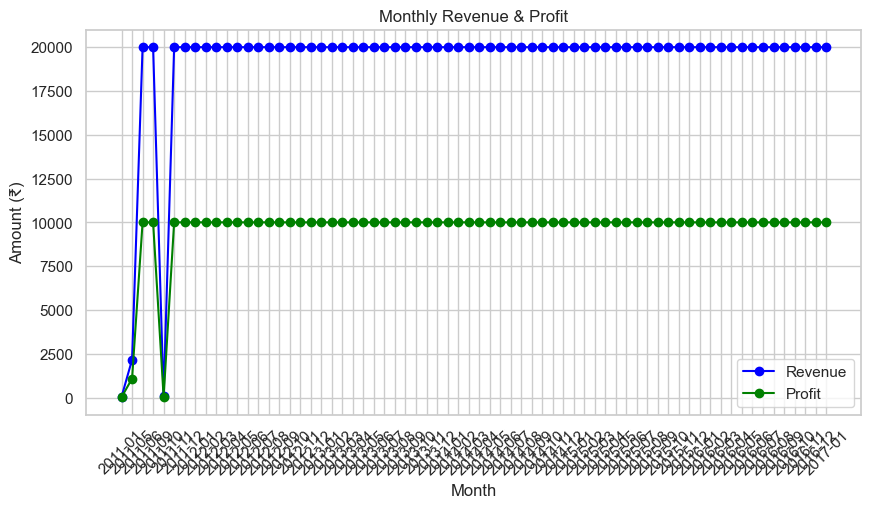

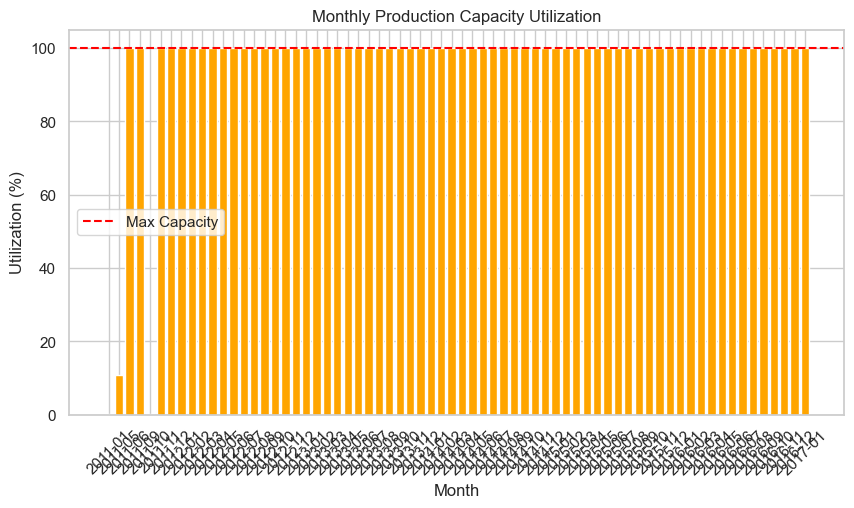

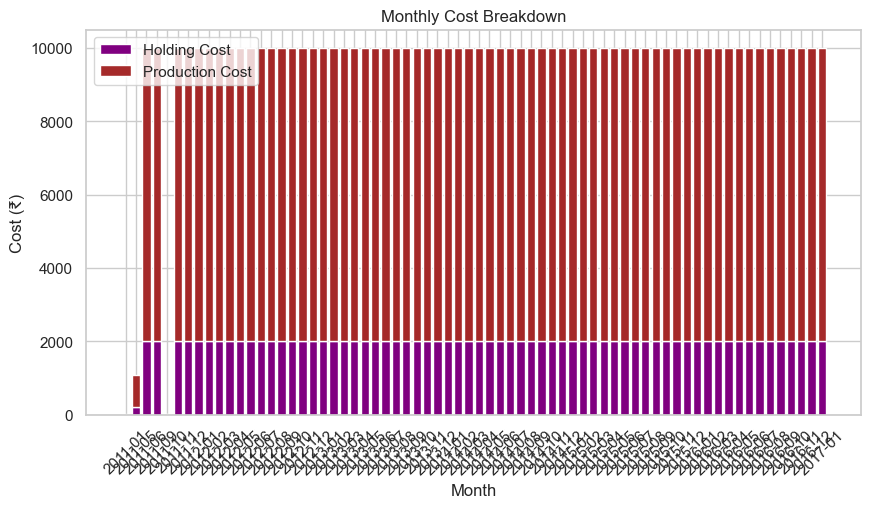

In [15]:
import matplotlib.pyplot as plt

# 1️⃣ Monthly Revenue & Profit
plt.figure(figsize=(10, 5))
plt.plot(metrics_df["Month"], metrics_df["Revenue"], label="Revenue", marker='o', color='blue')
plt.plot(metrics_df["Month"], metrics_df["Profit"], label="Profit", marker='o', color='green')
plt.title("Monthly Revenue & Profit")
plt.xlabel("Month")
plt.ylabel("Amount (₹)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# 2️⃣ Capacity Utilization
plt.figure(figsize=(10, 5))
plt.bar(metrics_df["Month"], metrics_df["Utilization(%)"], color='orange')
plt.axhline(y=100, color='red', linestyle='--', label='Max Capacity')
plt.title("Monthly Production Capacity Utilization")
plt.xlabel("Month")
plt.ylabel("Utilization (%)")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# 3️⃣ Cost Breakdown (Stacked Bar)
plt.figure(figsize=(10, 5))
plt.bar(metrics_df["Month"], metrics_df["Holding_Cost"], label="Holding Cost", color='purple')
plt.bar(metrics_df["Month"], metrics_df["Production_Cost"], bottom=metrics_df["Holding_Cost"], label="Production Cost", color='brown')
plt.title("Monthly Cost Breakdown")
plt.xlabel("Month")
plt.ylabel("Cost (₹)")
plt.xticks(rotation=45)
plt.legend()
plt.show()


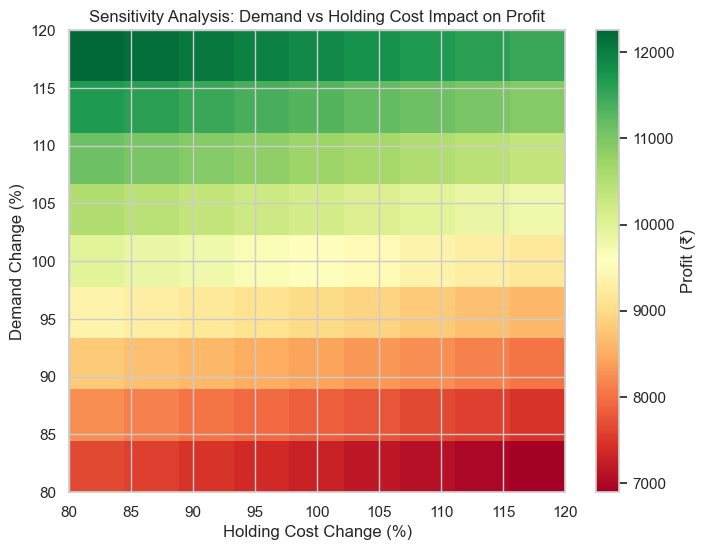

In [16]:


#  base parameters
base_demand = metrics_df["Demand"].mean()
base_holding_cost = metrics_df["Holding_Cost"].mean()
base_price = metrics_df["Revenue"].sum() / metrics_df["Demand"].sum()
production_cost_per_unit = metrics_df["Production_Cost"].sum() / metrics_df["Demand"].sum()

# Define ranges for sensitivity analysis
demand_changes = np.arange(0.8, 1.21, 0.05)   # -20% to +20% demand
holding_changes = np.arange(0.8, 1.21, 0.05)  # -20% to +20% holding cost

# Create results matrix
profit_matrix = np.zeros((len(demand_changes), len(holding_changes)))

# Calculate profit for each combination
for i, d_factor in enumerate(demand_changes):
    for j, h_factor in enumerate(holding_changes):
        demand = base_demand * d_factor
        revenue = demand * base_price
        holding_cost = base_holding_cost * h_factor
        production_cost = production_cost_per_unit * demand
        profit = revenue - (holding_cost + production_cost)
        profit_matrix[i, j] = profit

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(profit_matrix, cmap='RdYlGn', aspect='auto', origin='lower',
           extent=[holding_changes.min()*100, holding_changes.max()*100,
                   demand_changes.min()*100, demand_changes.max()*100])

plt.colorbar(label="Profit (₹)")
plt.xlabel("Holding Cost Change (%)")
plt.ylabel("Demand Change (%)")
plt.title("Sensitivity Analysis: Demand vs Holding Cost Impact on Profit")
plt.show()


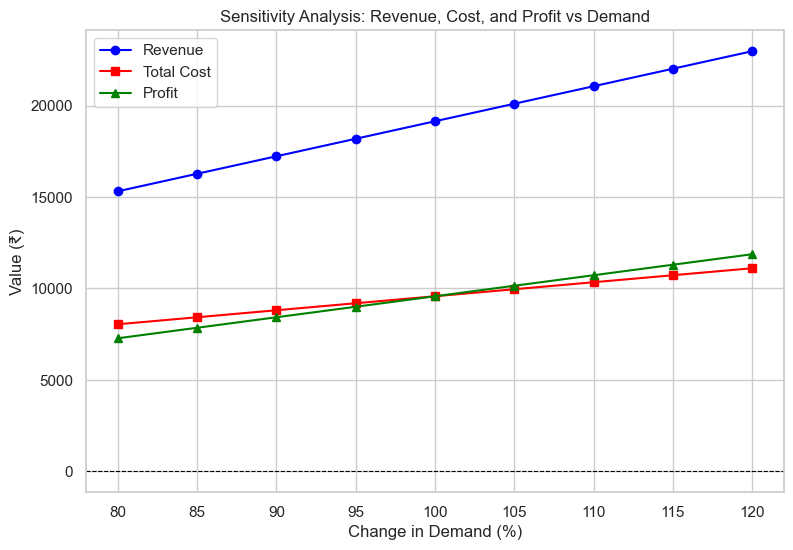

In [17]:


# Base parameters (replace with your dataset values if needed)
base_demand = metrics_df["Demand"].mean()
base_holding_cost = metrics_df["Holding_Cost"].mean()
base_price = metrics_df["Revenue"].sum() / metrics_df["Demand"].sum()
production_cost_per_unit = metrics_df["Production_Cost"].sum() / metrics_df["Demand"].sum()

# % changes in demand
percent_changes = np.arange(0.8, 1.21, 0.05)  # from -20% to +20%

# Store values
revenues = []
costs = []
profits = []

for factor in percent_changes:
    demand = base_demand * factor
    revenue = demand * base_price
    total_cost = base_holding_cost + (production_cost_per_unit * demand)
    profit = revenue - total_cost

    revenues.append(revenue)
    costs.append(total_cost)
    profits.append(profit)

# Plot
plt.figure(figsize=(9, 6))
plt.plot(percent_changes * 100, revenues, marker='o', label="Revenue", color='blue')
plt.plot(percent_changes * 100, costs, marker='s', label="Total Cost", color='red')
plt.plot(percent_changes * 100, profits, marker='^', label="Profit", color='green')

plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel("Change in Demand (%)")
plt.ylabel("Value (₹)")
plt.title("Sensitivity Analysis: Revenue, Cost, and Profit vs Demand")
plt.legend()
plt.grid(True)
plt.show()


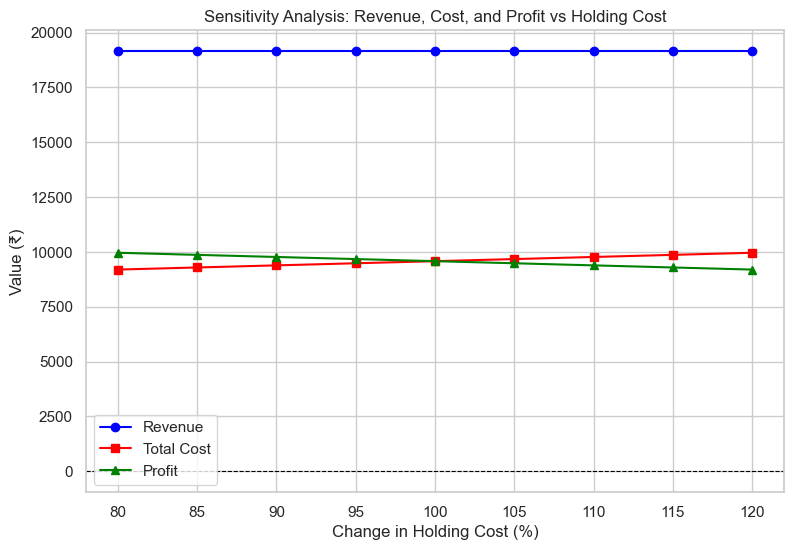

In [18]:
# % changes in holding cost
holding_changes = np.arange(0.8, 1.21, 0.05)  # from -20% to +20%

# Store values
revenues_h = []
costs_h = []
profits_h = []

for factor in holding_changes:
    holding_cost = base_holding_cost * factor
    revenue = base_demand * base_price
    total_cost = holding_cost + (production_cost_per_unit * base_demand)
    profit = revenue - total_cost

    revenues_h.append(revenue)
    costs_h.append(total_cost)
    profits_h.append(profit)

# Plot
plt.figure(figsize=(9, 6))
plt.plot(holding_changes * 100, revenues_h, marker='o', label="Revenue", color='blue')
plt.plot(holding_changes * 100, costs_h, marker='s', label="Total Cost", color='red')
plt.plot(holding_changes * 100, profits_h, marker='^', label="Profit", color='green')

plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel("Change in Holding Cost (%)")
plt.ylabel("Value (₹)")
plt.title("Sensitivity Analysis: Revenue, Cost, and Profit vs Holding Cost")
plt.legend()
plt.grid(True)
plt.show()


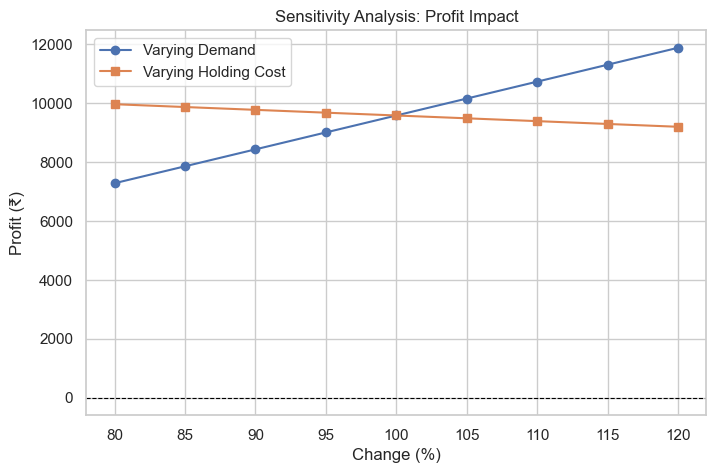

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Base parameters (replace with your dataset values if needed)
base_demand = metrics_df["Demand"].mean()
base_holding_cost = metrics_df["Holding_Cost"].mean()
base_price = metrics_df["Revenue"].sum() / metrics_df["Demand"].sum()
production_cost_per_unit = metrics_df["Production_Cost"].sum() / metrics_df["Demand"].sum()

# % changes
percent_changes = np.arange(0.8, 1.21, 0.05)  # from -20% to +20%

# Profit change when demand varies
profits_demand = []
for factor in percent_changes:
    demand = base_demand * factor
    revenue = demand * base_price
    profit = revenue - (base_holding_cost + production_cost_per_unit * demand)
    profits_demand.append(profit)

# Profit change when holding cost varies
profits_holding = []
for factor in percent_changes:
    holding_cost = base_holding_cost * factor
    revenue = base_demand * base_price
    profit = revenue - (holding_cost + production_cost_per_unit * base_demand)
    profits_holding.append(profit)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(percent_changes * 100, profits_demand, marker='o', label="Varying Demand")
plt.plot(percent_changes * 100, profits_holding, marker='s', label="Varying Holding Cost")

plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel("Change (%)")
plt.ylabel("Profit (₹)")
plt.title("Sensitivity Analysis: Profit Impact")
plt.legend()
plt.grid(True)
plt.show()
